# Import packages and data

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import fmin
import torch
import os, glob
import plotly.express as px

from indentation.indentationset import IndentationSet
from indentation.processing.find_contact import findContact_minimum, findContact_blackMagic, findContact_blackMagic_CNN
from indentation.processing.signal import do_nothing, crop_afm_temp, crop_start, crop_end
from indentation.processing.calculate_parameters import parameter_youngs_modulus, parameter_defelection_sensitivity
from indentation.processing.plotting import plot_curve_parameters_bar, plot_instance_parameters_bar, plot_mean_force_curves
from indentation.ml.models import ConvClassifier_1, ConvClassifier_2

[{'raw': {'force': array([-1.40920548e-05,  2.74650457e-05,  5.88253261e-06, ...,
        2.86311890e-02,  2.93020008e-02,  3.00185606e-02]), 'z': array([ 4.5723    ,  4.57206   ,  4.57098   , ..., -2.07899977,
       -2.08741977, -2.09080976]), 'time': array([0., 0., 0., ..., 0., 0., 0.])}, 'metadata': {'file': '\\\\d.ethz.ch\\groups\\mavt\\ecm\\Group\\File_Exchange\\Raoul_Paula\\2024_11_29\\afm_pdms35t1_ethanol_no2\\Image_00044_20241129_5.txt', 'name': 'Image_00044_20241129_5'}}, {'raw': {'force': array([3.84568234e-06, 1.34486919e-05, 1.04640853e-05, ...,
       2.89042330e-02, 2.98840130e-02, 3.01156429e-02]), 'z': array([ 4.5691    ,  4.56903   ,  4.56827   , ..., -1.94127977,
       -1.94974976, -1.95325976]), 'time': array([0., 0., 0., ..., 0., 0., 0.])}, 'metadata': {'file': '\\\\d.ethz.ch\\groups\\mavt\\ecm\\Group\\File_Exchange\\Raoul_Paula\\2024_11_29\\afm_pdms35t1_ethanol_no2\\Image_00044_20241129_3.txt', 'name': 'Image_00044_20241129_3'}}, {'raw': {'force': array([-1.12947

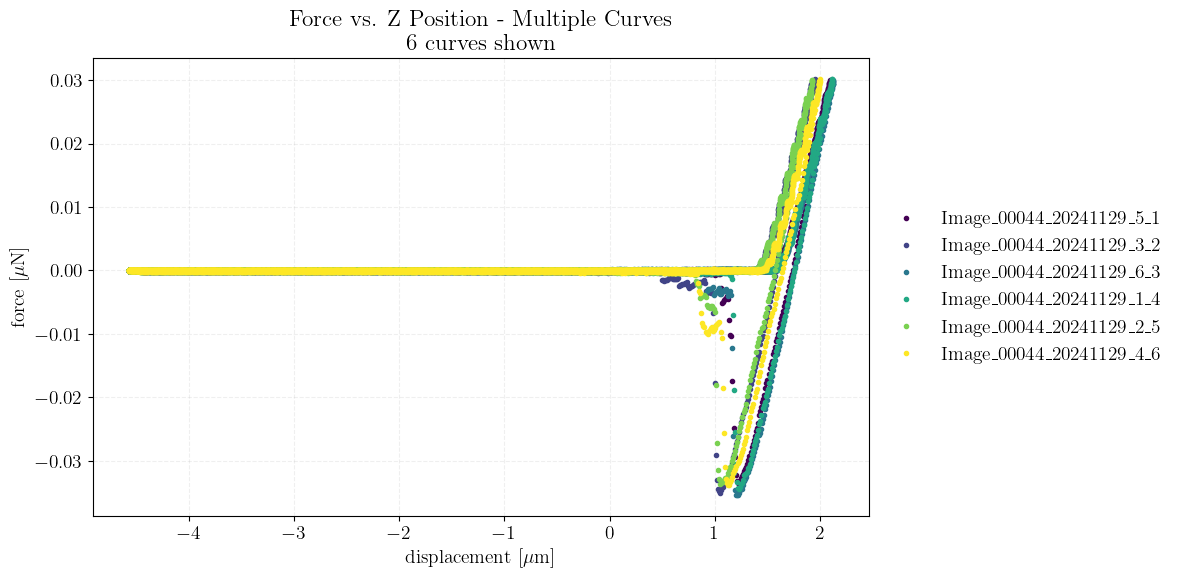

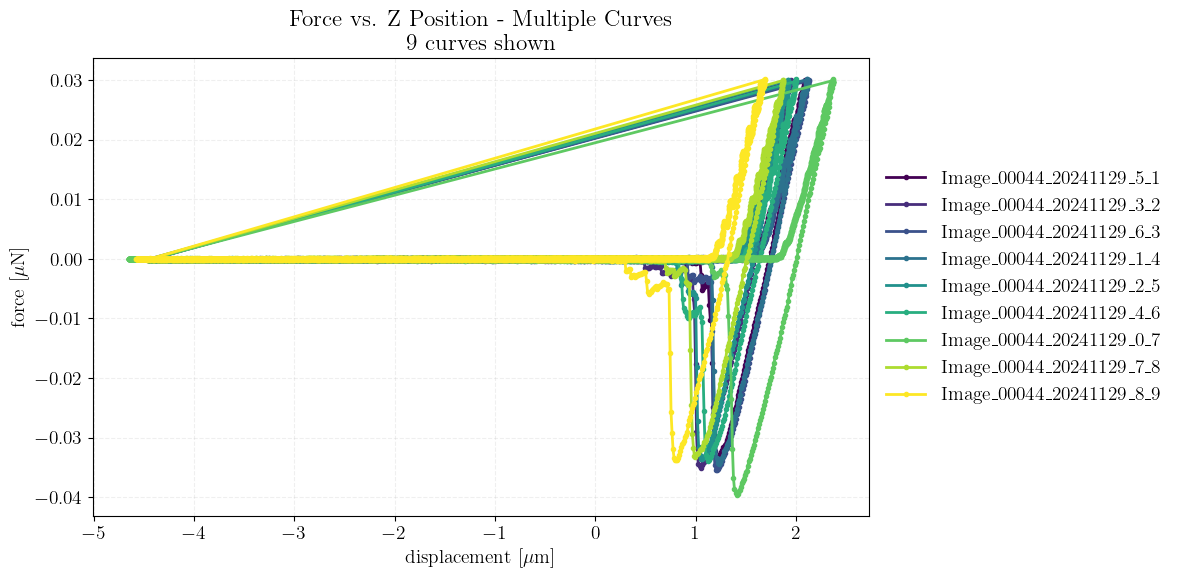

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [3]:
paths = glob.glob(r"G:\File_Exchange\Raoul_Paula\2024_11_29\afm_pdms35t1_ethanol_no2\*.txt")

afm = IndentationSet(paths, exp_type="afm")
afm.delete_curves([1, 2, 3])
print(afm.data[0])
afm.plot_all(linestyle="")

afm.restore_all()

afm.plot_all(linestyle="-")

# Processing data

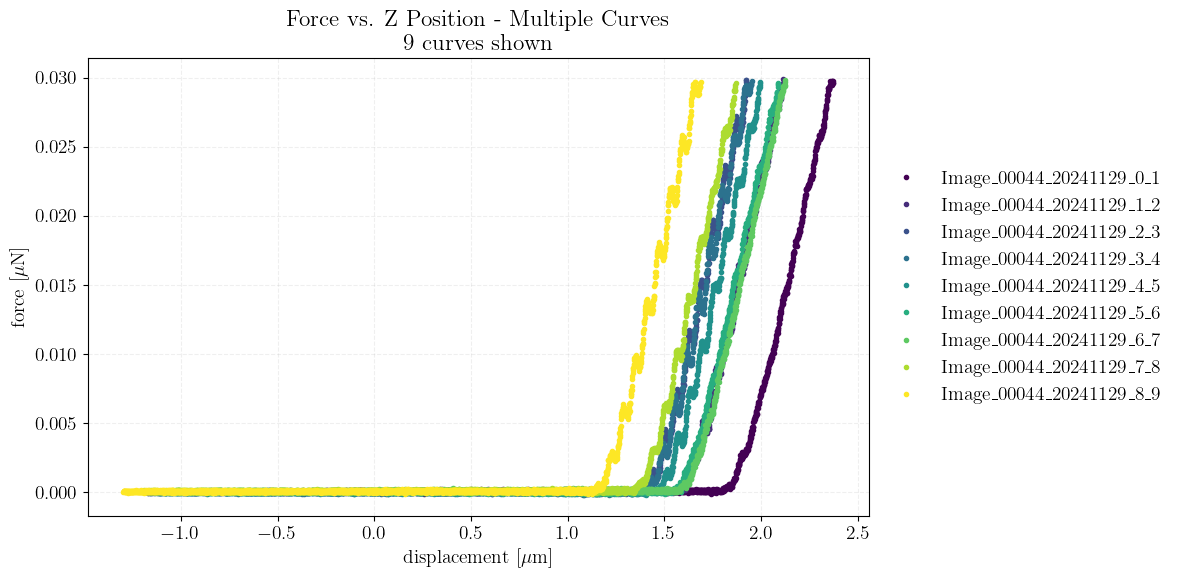

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n9 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [25]:
processing_pl = [crop_afm_temp]

afm.process_raw(processing_pl)
afm.plot_all(linestyle="")

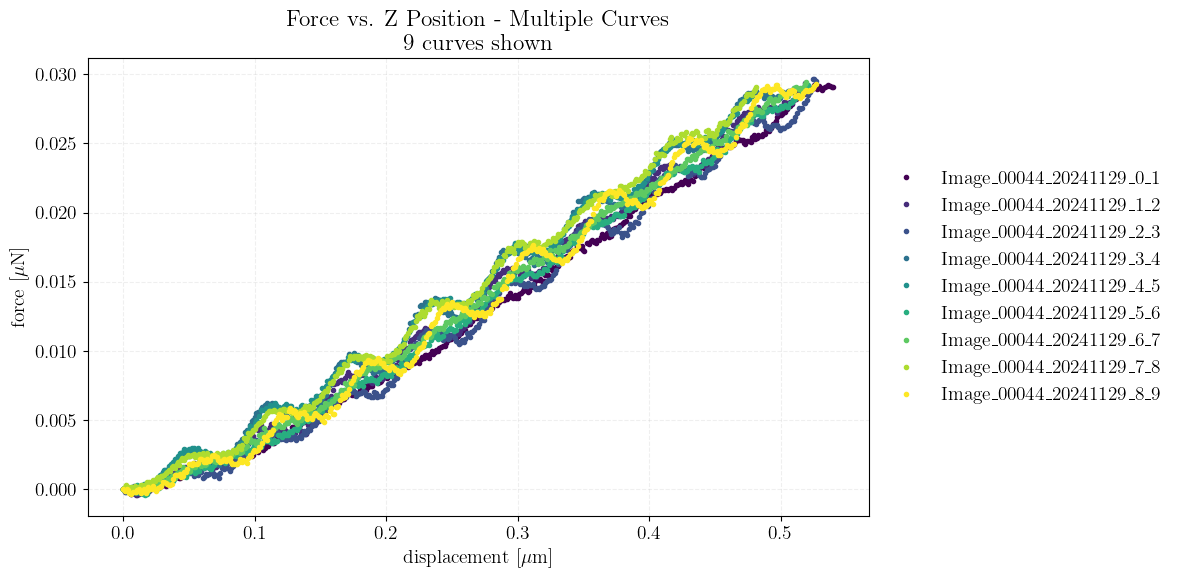

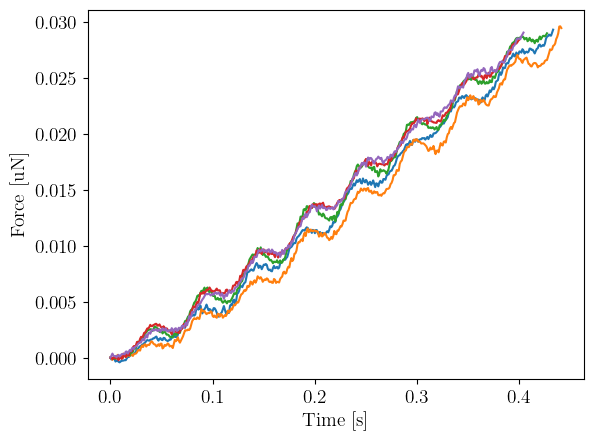

In [37]:
processing_pl = [crop_afm_temp, findContact_blackMagic]

afm.process_raw(processing_pl)
afm.plot_all(linestyle="")

f_s = 1000 # sampling rate

for i in [1, 2, 3, 4, 7]:
    n = len(afm.data[i]["processed"]["force"])
    time = np.linspace(0, n-1, n) / f_s

    # fig = px.scatter(x=time, y=afm.data[i]["processed"]["force"])
    # fig.show()
    
    #plt.figure()
    plt.plot(time, afm.data[i]["processed"]["force"])
    plt.xlabel("Time [s]")
    plt.ylabel("Force [uN]")
    #plt.show()

plt.show()

Mean and std: 20.546129581132636 0.5389237208993485


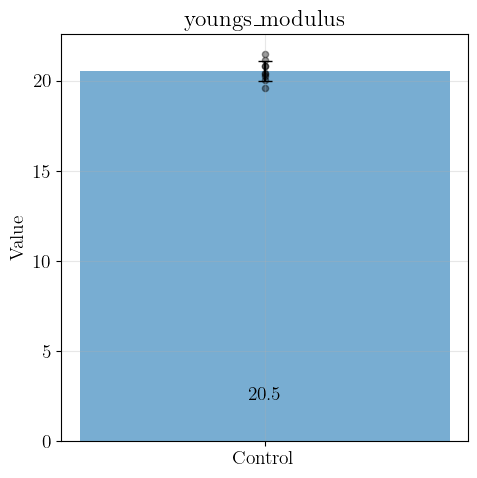

In [13]:
function_arguments = dict(radius=5, nu=0.5, cutoff=10, keyname="youngs_modulus")
afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_curve_parameters_bar(afm,
                         parameter_names=['youngs_modulus'],
                         labels=['Control'],
                         figsize=(5,5))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 62
21982.63145983219


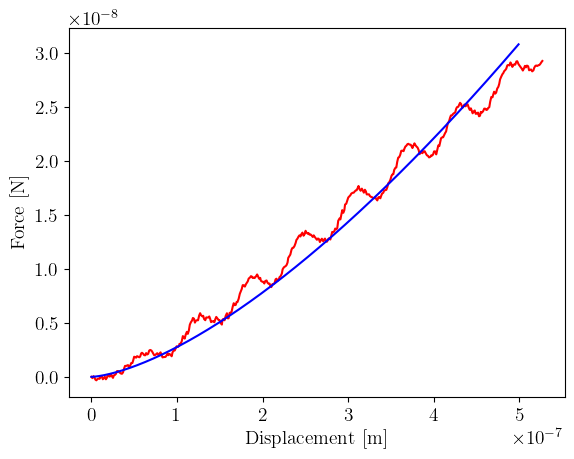

In [15]:
def hertzian(E, R, nu, z):
    hertz_F = 4.0 / 3.0 * E * np.sqrt(R) / (1 - nu*nu) * np.power(z, 3.0/2.0)
    
    return hertz_F

def sse(param, R, nu, F, z, cutoff):
    E = param
    ix = np.where(z > cutoff * R)[0]

    if(len(ix) == 0):
        ix = len(F) - 1
    else:
        ix = ix[0]

    force = F[:ix]
    disp_z = z[:ix]
    
    hertz_F = hertzian(E, R, nu, disp_z)

    sse_value = np.sum((force-hertz_F)**2.0)

    return sse_value

initial_guess = 50e3
R = 5 / 1e6
nu = 0.5
F = afm.data[8]["processed"]["force"] / 1e6
z = -afm.data[8]["processed"]["z"] / 1e6
cutoff = 0.10
result = fmin(sse, initial_guess, args=(R, nu, F, z, cutoff))
print(result[0])

ix = np.where(z > cutoff * R)[0]

if(len(ix) == 0):
    ix = len(F) - 1
else:
    ix = ix[0]
    
hertz_fit = hertzian(result[0], R, nu, z[:ix])

plt.figure()
plt.plot(z, F, 'r-')
plt.plot(z[:ix], hertz_fit, 'b-')
plt.xlabel("Displacement [m]")
plt.ylabel("Force [N]")
plt.show()

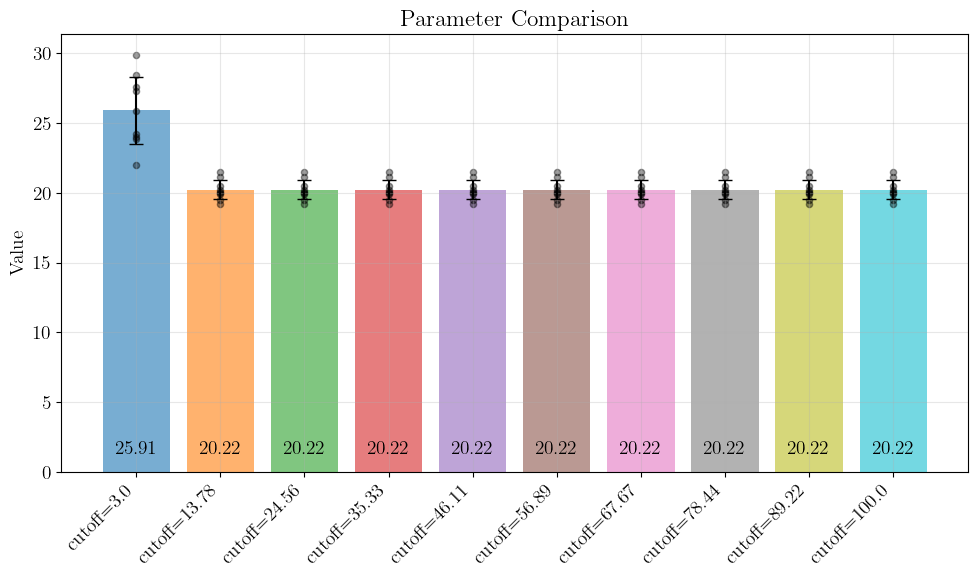

In [10]:
cutoffs = np.linspace(3, 100, 10)

for cutoff in cutoffs:
    function_arguments = dict(radius=5, nu=0.5, cutoff=cutoff, keyname="cutoff="+str(np.round(cutoff, 2)))
    afm.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_instance_parameters_bar(afm,
                         parameter_names=[*["cutoff="+str(np.round(cutoff, 2)) for cutoff in cutoffs]],
                         figsize=(10,6))